# Выбор локации для скважины

Нужно решить, где бурить новую скважин.
Шаги для выбора локации:
В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
Строят модель для предсказания объёма запасов в новых скважинах;
Выбирают скважины с самыми высокими оценками значений;
Определяют регион с максимальной суммарной прибылью отобранных скважин.
Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 
**Задача:** построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.


## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


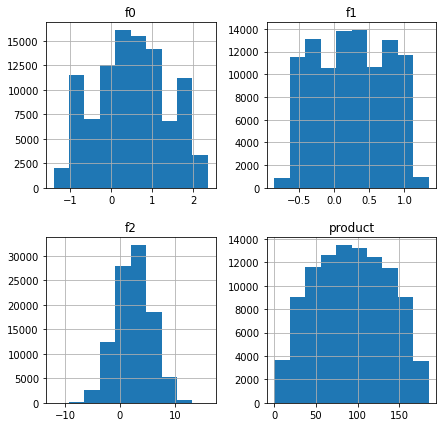

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_1.info()
print(data_1.head())
data_1.hist(figsize=(7, 7))
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305


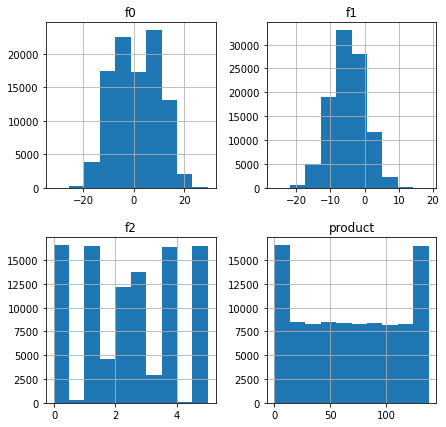

In [3]:
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_2.info()
print(data_2.head())
data_2.hist(figsize=(7, 7))
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


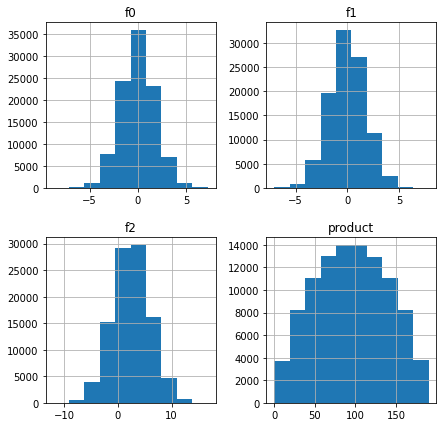

In [4]:
data_3 = pd.read_csv('/datasets/geo_data_2.csv')
data_3.info()
print(data_3.head())
data_3.hist(figsize=(7, 7))
plt.show()

Категориальных признаков нет.

### Обработка данных

Проверим на наличие дубликатов и попусков.

In [5]:
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())
print(data_3.duplicated().sum())

print(data_1.isna().sum())
print(data_2.isna().sum())
print(data_3.isna().sum())

0
0
0
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


В данных нет явных дубликатов и попусков.

## Обучение и проверка модели

###  Обучающая и валидационная выборки

Целевой признак - столбец product - объем запасов в скважине. 

Разделим данные на обучающую и валидационную выборки в соотношении 75:25.
Так как нет категориальных признаков, ничего преобразовывать не надо.

При разбиении на выборки удалим столбец с id, тк он не влияет на объем запасов.

In [6]:
def divide (df):
    features = df.drop(['product'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=.25, random_state=12345)
    
    #Масштабирование признаков.
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    print('features_train', features_train.shape,
         '\nfeatures_valid', features_valid.shape,
         '\ntarget_train', target_train.shape,
         '\ntarget_valid', target_valid.shape,
         '\n')
    return(features_train, features_valid, target_train, target_valid)

In [18]:
#Разобьем данные на выборки
features_train_1, features_valid_1, target_train_1, target_valid_1 = divide(data_1.drop(['id'], axis=1))
features_train_2, features_valid_2, target_train_2, target_valid_2 = divide(data_2.drop(['id'], axis=1))
features_train_3, features_valid_3, target_train_3, target_valid_3 = divide(data_3.drop(['id'], axis=1))
pd.options.mode.chained_assignment = None

features_train (75000, 3) 
features_valid (25000, 3) 
target_train (75000,) 
target_valid (25000,) 

features_train (75000, 3) 
features_valid (25000, 3) 
target_train (75000,) 
target_valid (25000,) 

features_train (75000, 3) 
features_valid (25000, 3) 
target_train (75000,) 
target_valid (25000,) 


### Обучение модели линейной регрессии

In [8]:
def mod (features_train, target_train, features_valid):
    model = LinearRegression()
    model.fit(features_train, target_train) 
    return(model, model.predict(features_valid))

model_1, predictions_valid_1 = mod(features_train_1, target_train_1, features_valid_1)
model_2, predictions_valid_2 = mod(features_train_2, target_train_2, features_valid_2)
model_3, predictions_valid_3 = mod(features_train_3, target_train_3, features_valid_3)

### Средний запас предсказанного сырья 

In [24]:
print('Правильное значение среднего запаса сырья')
print('Регион 1:', target_valid_1.mean())
print('Регион 2:', target_valid_2.mean())
print('Регион 3:', target_valid_3.mean())

Правильное значение среднего запаса сырья
Регион 1: 92.07859674082927
Регион 2: 68.72313602435997
Регион 3: 94.88423280885438


In [10]:
print('Средний запас предсказанного сырья')
print('Регион 1:', predictions_valid_1.mean())
print('Регион 2:', predictions_valid_2.mean())
print('Регион 3:', predictions_valid_3.mean())

Средний запас предсказанного сырья
Регион 1: 92.59256778438035
Регион 2: 68.728546895446
Регион 3: 94.96504596800489


Средние значения правильных и предсказанных результатов достаточно близки друг к другу.
Для второго региона значение среднего запаса сырья примерно на 25% меньше, чем для первого и третьего.

Чем меньше значение среднего, тем меньшую прибыль может принести скважина. Наименее привлекательным с точки зрения среднего запаса оказался 2-й регион.

### RMSE модели

In [11]:
rmse_1 = mean_squared_error(target_valid_1, predictions_valid_1)**.5
rmse_2 = mean_squared_error(target_valid_2, predictions_valid_2)**.5
rmse_3 = mean_squared_error(target_valid_3, predictions_valid_3)**.5
print("RMSE:")
print('Регион 1:', rmse_1)
print('Регион 2:', rmse_2)
print('Регион 3:', rmse_3)

RMSE:
Регион 1: 37.5794217150813
Регион 2: 0.893099286775617
Регион 3: 40.02970873393434


Чем меньше среднеквадратичное отклонение, тем ближе результат к среднему всех результатов. Наименьший RMSE у 2-го региона - расброс данных в нем относительно среднего значения наименьший.

### Проверка моделей на адекватность

Проверим модели на адекватность - сравним их с наивной моделью (в данном случае, с моделью, которая будет выдавать средние значения запаса сырья в регионе).

In [12]:
def adeq (df):
    target = df['product']
    predictions = pd.Series(target.mean(), index=target.index) 
    rmse = mean_squared_error(target, predictions)**.5
    print("RMSE случайной модели:", rmse, '\n')
    
print('Для 1-го региона:')
adeq(data_1)

print('Для 2-го региона:')
adeq(data_2)

print('Для 3-го региона:')
adeq(data_3)
    

Для 1-го региона:
RMSE случайной модели: 44.2884696928441 

Для 2-го региона:
RMSE случайной модели: 45.94419317228633 

Для 3-го региона:
RMSE случайной модели: 44.74969731878746 


RMSE всех моделей больше, чем RMSE наивной модели. Таким образом, все модели можно считать адекватными.

## Подготовка к расчёту прибыли

### Входные данные

 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с  - наибольшей средней прибылью.

In [13]:
budget = 10000             # Бюджет на разработку скважин в регионе (млн.)
points = 500               # Число точек для исследования
final_points = 200         # Число лучших точек для исследования
income_per_barrel = .45    # Доход за единицу продукта (1000 баррелей) (млн.)
max_loss_prob = .025       # Максимально допустимая вероятность убытков

### Достаточный объём сырья для безубыточной разработки новой скважины

In [14]:
expenses = budget/final_points                        # Затраты на разработку одной скважины
min_quantity_to_cover = expenses/income_per_barrel    # Кол-во продукта (тысяч баррелей), необходимого для покрытия затрат 
                                                      # на одну скважину
print('Затраты на разработку одной скважины:', expenses, 'млн.руб.')
print('Необходимый объем сырья для покрытия затрат на разработку одной скважины:', min_quantity_to_cover, 'тыс. баррелей')

Затраты на разработку одной скважины: 50.0 млн.руб.
Необходимый объем сырья для покрытия затрат на разработку одной скважины: 111.11111111111111 тыс. баррелей


Для всех регионов, средний запас сырья меньше необходимого, что свидетельствует о высоком риске того, что затраты на разработку скважины не окупятся.

Наиболее приорететными на данном этапе являются регионы с высоким средним запасом сырья - 1-й и 3-й регионы. Для каждого из регионов, рассчитаем процентное соотношение скважин, для которых средний запас сырья больше необходимого.

In [15]:
for i in range (99, 50, -1):
    if data_1['product'].quantile(i/100) > 112:
        i_1 = i/100
    if data_2['product'].quantile(i/100) > 112:
        i_2 = i/100
    if data_3['product'].quantile(i/100) > 112:
        i_3 = i/100
        

print('Регион 1')
print('Процент подходящих скважин:', (1-i_1)*100, '%')
print('Минимальное из подходящих значение запаса сырья:', data_1['product'].quantile(i_1),'\n')
print('Регион 2')
print('Процент подходящих скважин:', (1-i_2)*100, '%')
print('Минимальное из подходящих значение запаса сырья:', data_2['product'].quantile(i_2),'\n')
print('Регион 3')
print('Процент подходящих скважин:', (1-i_3)*100, '%')
print('Минимальное из подходящих значение запаса сырья:', data_3['product'].quantile(i_3),'\n')

Регион 1
Процент подходящих скважин: 35.0 %
Минимальное из подходящих значение запаса сырья: 113.16725066331651 

Регион 2
Процент подходящих скважин: 16.000000000000004 %
Минимальное из подходящих значение запаса сырья: 134.76630515769844 

Регион 3
Процент подходящих скважин: 37.0 %
Минимальное из подходящих значение запаса сырья: 112.6070206646233 


Наибольший процент подходящих скважин в регионах 1 и 3.

## Расчёт прибыли и рисков 

### Расчет прибыли

In [16]:
# Функция расчета прибыли для 200 лучших точек
def income (target_valid, predictions_valid):
    predictions_valid = pd.Series(predictions_valid)
    predictions_sort = predictions_valid.sort_values(ascending=False)[:final_points]
    target_sort = target_valid.reset_index(drop=True)[predictions_sort.index]
    return(target_sort.sum()*income_per_barrel-budget)

print('Прибыль с 200 скважин\n')
print('Регион 1:', income(target_valid_1,predictions_valid_1), 'млн.')
print('Регион 2:', income(target_valid_2,predictions_valid_2), 'млн.')
print('Регион 3:', income(target_valid_3,predictions_valid_3), 'млн.')

Прибыль с 200 скважин

Регион 1: 3320.8260431398503 млн.
Регион 2: 2415.086696681512 млн.
Регион 3: 2710.3499635998323 млн.


### Расчет риска и прибыли техникой Bootstrap

In [26]:
state = RandomState(12345) 

def income_bootstrap (target_valid, predictions_valid):
    values = []
    for i in range(1000):
        sample = pd.Series(predictions_valid).sample(n=points, replace=True, random_state=state)
        values.append(income(target_valid, sample))
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Средняя прибыль:', values.mean(), 'млн.')
    print('Риск:', values.apply(lambda x: x < 0).sum()/len(values)*100, '%')
    print('95% доверительный интервал:', lower, '-', upper,'\n') 
    
    return ()

print ('Регион 1')
income_bootstrap(target_valid_1, predictions_valid_1)
print ('Регион 2')
income_bootstrap(target_valid_2, predictions_valid_2)
print ('Регион 3')
income_bootstrap(target_valid_3, predictions_valid_3)

Регион 1
Средняя прибыль: 396.16498480237146 млн.
Риск: 6.9 %
95% доверительный интервал: -111.21554589049533 - 909.7669415534222 

Регион 2
Средняя прибыль: 461.15581727724 млн.
Риск: 0.7000000000000001 %
95% доверительный интервал: 78.05081075174127 - 862.952060263724 

Регион 3
Средняя прибыль: 392.9504751706049 млн.
Риск: 6.5 %
95% доверительный интервал: -112.22762537857456 - 934.562914551164 


()

Для всех трех регионов, средний доход положительный.
Наибольшая средняя прибыль и наименьший риск оказались у 2-го региона - он и является приоритетным для разработки скважин.

Также, следует отметить, что доверительный интервал для 2-го региона меньше, чем доверительный интервал для 1-го и 3-го регионов. 

## Вывод

В ходе работы над проектом была проведена предобработка данных:
- Данные проврены на наличие дубликатов и пропусков
- Данные стандартизированы

Была обучена наиболее подходящая для данной задачи модель Линейной регрессии.


**Предсказан средний запас сырья.**
- Регион 1: 92.59256778438035
- Регион 2: 68.728546895446
- Регион 3: 94.96504596800489

Средние значения правильных и предсказанных результатов достаточно близки друг к другу. Для второго региона значение среднего запаса сырья примерно на 25% меньше, чем для первого и третьего.

**Рассчитано среднеквадратическое отклонение модели (метрика RMSE).**
- Регион 1: 37.5794217150813
- Регион 2: 0.893099286775617
- Регион 3: 40.02970873393434

Чем меньше среднеквадратичное отклонение, тем ближе результат к среднему всех результатов. Наименьший RMSE у 2-го региона - расброс данных в нем относительно среднего значения наименьший.

Проведена проверка моделей на адекватность. Выполнено сравнение параметра RMSE используемых в проекте моделей и наивной модели, предсказывающей среднее значение.
RMSE всех моделей больше, чем RMSE наивной модели. Таким образом, все модели можно считать адекватными.

Рассчитан необходимый объем сырья для покрытия затрат на разработку одной скважины: 111 тыс. баррелей.
(Средний запас сырья во всех регионах меньше необходимого)

**Рассчитан процент подходящих скважин.**
- Регион 1: 35.0 %
- Регион 2: 16.0 %
- Регион 3: 37.0 %

**Расчет риска и прибыли с применением техники Bootstrap**

*Регион 1*
Средняя прибыль: 396 млн.
Риск: 6.9 %
95% доверительный интервал: (-111 - 910)

*Регион 2*
Средняя прибыль: 461 млн.
Риск: 0.7 %
95% доверительный интервал: (78 - 863)

*Регион 3*
Средняя прибыль: 393 млн.
Риск: 6.5 %
95% доверительный интервал: (-112 - 935) 

Для всех трех регионов, средний доход положительный.
Наибольшая средняя прибыль и наименьший риск оказались у 2-го региона - он и является приоритетным для разработки скважин.

Также, следует отметить, что доверительный интервал для 2-го региона меньше, чем доверительный интервал для 1-го и 3-го регионов.

**Итого, 2-й регион наиболее приоритетный для разработки скважин.**